In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
from scipy.optimize import minimize
import yfinance as yf
import seaborn as sns
%load_ext autoreload
%autoreload 2
import risk_module_d as rk

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Markowitz Portfolio Optimization

In [33]:
#getting data for the returns from yfinance
tickers = ['TATAMOTORS.NS','DABUR.NS','BAJAJ-AUTO.NS','BERGEPAINT.NS','HAVELLS.NS','HDFCBANK.NS','TORNTPHARM.NS','HINDUNILVR.NS','RELIANCE.NS','TITAN.NS']
data = yf.download(tickers, start='2008-6-2', end='2023-6-2') #fetching monthly data for 15 years
price_data=data['Close'] #taking the closing price to determine returns
returns = price_data[tickers].pct_change().dropna()
returns.dropna(inplace=True)
rets = pd.DataFrame(returns)



[*********************100%***********************]  10 of 10 completed


In [51]:
cov_matrix = rets.cov() #to get covariance between the assets
cov_matrix.head()

,TATAMOTORS.NS,DABUR.NS,BAJAJ-AUTO.NS,BERGEPAINT.NS,HAVELLS.NS,HDFCBANK.NS,TORNTPHARM.NS,HINDUNILVR.NS,RELIANCE.NS,TITAN.NS
TATAMOTORS.NS,0.000835,0.000115,0.000183,0.000140,0.000247,0.000193,0.000123,0.000088,0.000249,0.000214
DABUR.NS,0.000115,0.000271,0.000068,0.000079,0.000101,0.000068,0.000060,0.000090,0.000079,0.000085
BAJAJ-AUTO.NS,0.000183,0.000068,0.000354,0.000082,0.000123,0.000121,0.000076,0.000072,0.000133,0.000127
BERGEPAINT.NS,0.000140,0.000079,0.000082,0.000457,0.000128,0.000075,0.000073,0.000069,0.000098,0.000105
HAVELLS.NS,0.000247,0.000101,0.000123,0.000128,0.000561,0.000128,0.000083,0.000073,0.000150,0.000146


In [52]:
ann_rets = pd.Series(rk.annualized_return(rets))
ann_rets

0    0.115153
1    0.181390
2    0.207978
3    0.304086
4    0.255364
5    0.186167
6    0.297781
7    0.181018
8    0.103063
9    0.305176
dtype: float64

<Axes: >

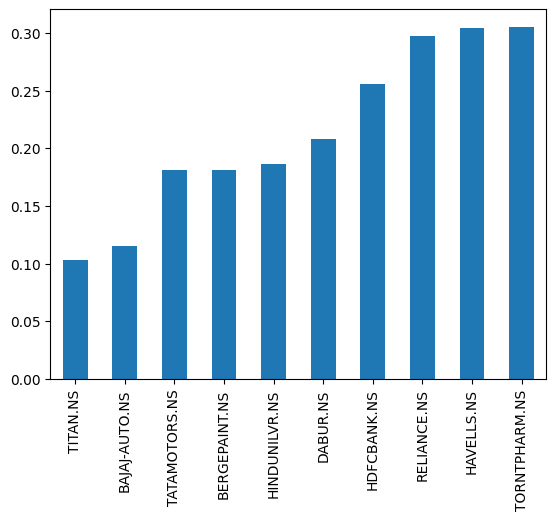

In [53]:
#plotting the annual returns of the assets
column_names = price_data.columns
ann_rets.index=column_names
ann_rets.sort_values().plot.bar()

In [54]:
#calculating weights to optimize for the maximum sharpe ratio using msr function from the risk module
weights=rk.msr(0.03,ann_rets, cov_matrix)
#return of the optimized portfolio
r=rk.portfolio_return(weights,ann_rets)
#volatility of the optimized portfolio
vol=rk.portfolio_vol(weights,cov_matrix)

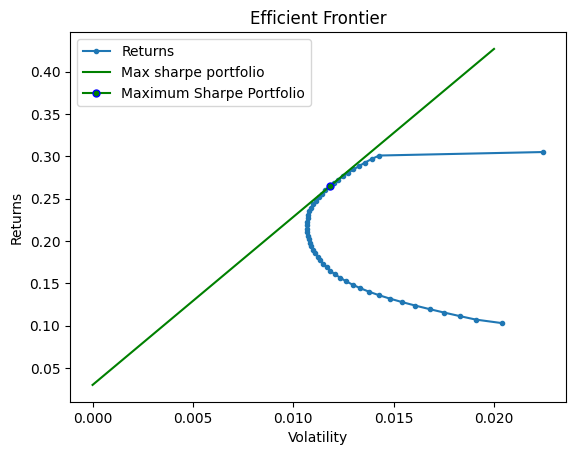

In [55]:
#PLotting the efficient frontier, and locating the portfolio having maximum Sharpe ratio
rk.plot_ef(50, ann_rets, cov_matrix)
#Plotting the line for returns of the risk free asset (risk free returns = 3%)
x=[0,0.020]
y=[0.03,0.020*(r-0.03)/vol+0.03]
plt.title("Efficient Frontier")
plt.plot(x,y,label='Max sharpe portfolio',color="green")
plt.plot(vol,r, color='green', marker='.',markersize=10, markeredgecolor= 'blue',label="Maximum Sharpe Portfolio")
plt.ylabel("Returns")
plt.legend()
plt.show()

In [56]:
sharpe = (r-0.03)/vol
print(f"The return of the portfolio is {r*100}%")
print(f"The volatility of the portfolio is {vol*100}%")
print(f"The Sharpe Ratio of the portfolio is {sharpe}")

The return of the portfolio is 26.515255825020528%
The volatility of the portfolio is 1.184633442627884%
The Sharpe Ratio of the portfolio is 19.850238038913037


# CPPI

In [57]:
#Taking the same 10 assets as risky assets and using them as risky assets in CPPI
df = rk.run_cppi( rets,safe_r=None, m=3, start=1000, floor=0.8, riskfree_rate=0.03, drawdown=None)